<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

print("done all")

done all


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
from nltk import tokenize

print("done all")

done all


In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [8]:
# посмотрим, что там есть
unique_labels = set([example['label'] for example in dataset['train']])
print(unique_labels)


{0, 1}


In [9]:
# сколько каких категорий
number_of_negatives = sum(1 for example in dataset['train'] if example['label'] == 0)
print(number_of_negatives)
number_of_positives = sum(1 for example in dataset['train'] if example['label'] == 1)
print(number_of_positives)
total_number = len(dataset['train'])
print(total_number)


12500
12500
25000


In [10]:
# пару примеров
i = 0
for example in dataset['train']:
    if i <= 1:
        print(example['text'])
        print(example['label'])
    i +=1

    

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [11]:
import re

sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

for text in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(text, language='english'): 
        words = re.findall(r'\w+', sentence) # может можно и лучше побить по словам
        if len(words) <= word_threshold:
            sentences.append(sentence)


  0%|          | 0/25000 [00:00<?, ?it/s]

In [12]:
# посмотрим, какая макс длина в словах получилась, и какое там предложение
max_length = max(len(sentence.split()) for sentence in sentences)
print(max_length)

for sentence in sentences:
    if len(sentence.split()) == max_length:
        print(sentence)
        



36
No Zeus + no imagination + no sparks = millions of little dollar bills with tiny wings - each made from the hundreds of licensing agreements required to use the clips - flying out the window.


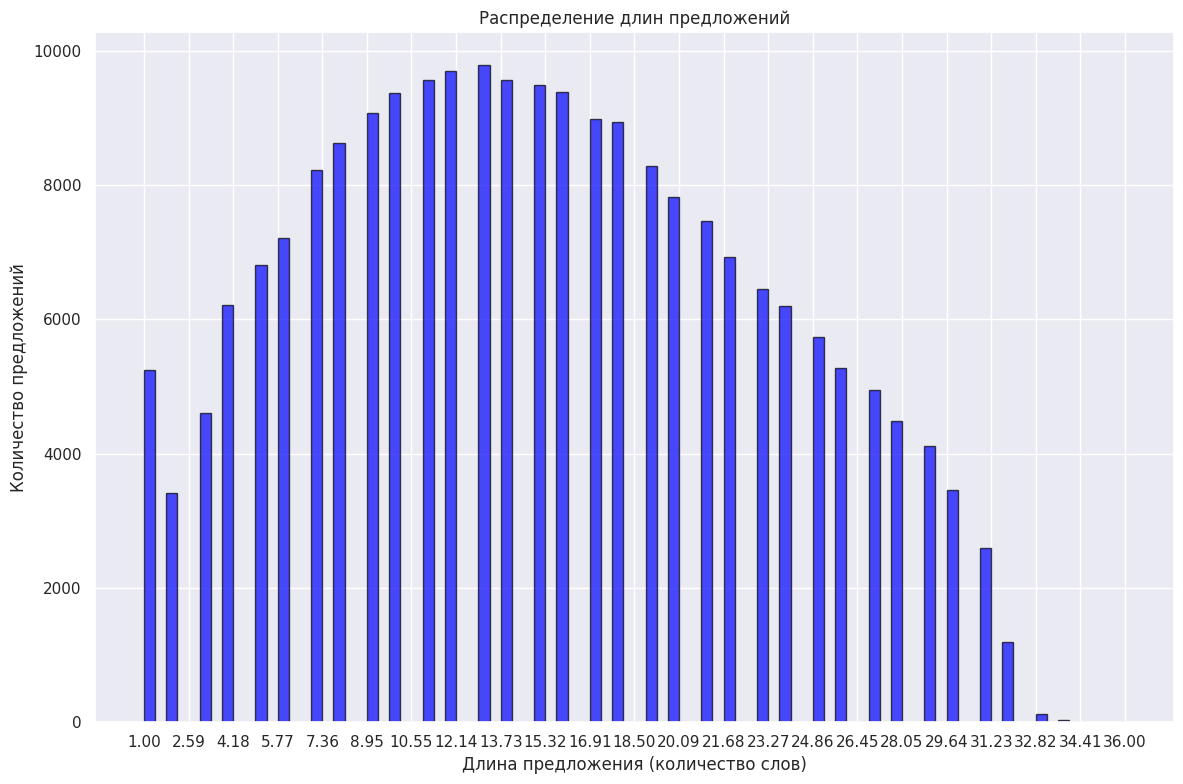

In [13]:
# посмотрим распределение по длинам предложений

import matplotlib.pyplot as plt
import numpy as np


# Для демонстрации создадим массив случайных длин предложений
np.random.seed(0) # Для воспроизводимости результатов
sentence_lengths = []
for sentence in sentences:
    sentence_lengths.append(len(sentence.split()))

# Построение гистограммы длин предложений
plt.figure(figsize=(12, 8))

# Для большого количества данных лучше использовать больше корзин для гистограммы
# или позволить matplotlib автоматически определить оптимальное их количество.
# Автоматическое определение количества корзин:
bin_edges = np.histogram_bin_edges(sentence_lengths, bins='auto')

plt.hist(sentence_lengths, bins=bin_edges, alpha=0.7, color='blue', edgecolor='black')

plt.title('Распределение длин предложений')
plt.xlabel('Длина предложения (количество слов)')
plt.ylabel('Количество предложений')

# Установим шаг для отметок на оси X для улучшения читаемости
tick_step = max(1, len(bin_edges) // 20) # Не более 20 отметок на оси X
plt.xticks(bin_edges[::tick_step])

plt.grid(True) # Добавляем сетку для лучшей ориентации
plt.tight_layout() # Автоматическая корректировка подписей, чтобы они не перекрывались

plt.show()


устраивает. Не буду бороться с тем, что   words = re.findall(r'\w+', sentence) оставляет + - и т.п.

In [14]:
print("Всего предложений:", len(sentences))

Всего предложений: 219312


Посчитаем для каждого слова его встречаемость.

In [15]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences):
    tokenized_sentence = word_tokenize(sentence, language='english')
    for word in tokenized_sentence:
        words[word] += 1

  0%|          | 0/219312 [00:00<?, ?it/s]

In [16]:
len(words)

93181

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [17]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

most_common_words = words.most_common(vocab_size) # на любой чих тут встроенные методы -)

# Наполнение словаря
for word, _ in most_common_words:
    vocab.add(word)

In [18]:
len(vocab)

40004

In [19]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [20]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [21]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

print("ok")

ok


In [22]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)
    
print("ok")

ok


In [23]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [24]:
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(temp_sentences, test_size=0.5)


train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 16 # это борьба с ООМ (OutOfMemoryError: CUDA out of memory. 
# Tried to allocate 3.74 GiB. GPU 0 has a total capacty of 14.75 GiB of which 2.96 GiB is free. 
# Process 3799 has 11.78 GiB memory in use. Of the allocated memory 11.57 GiB is allocated by PyTorch, 
# and 77.50 MiB is reserved by PyTorch but unallocated. 
# If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  
# See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [25]:
print(train_dataset[123])

[10792, 33872, 6558, 35546, 30637, 4378, 38698, 27227, 12817, 13323, 11333, 9661, 13741, 9810, 33027, 23346, 20511, 33072, 15622, 15872]


In [26]:
 print([ind2word[i] for i in train_dataset[123]])


['<bos>', 'Definitely', 'my', 'two', 'favourite', 'films', 'of', 'all', 'time', ',', 'I', 'watch', 'them', 'at', 'least', 'once', 'a', '<unk>', '.', '<eos>']


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [27]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

print('ok')

ok


### Train loop (1 балл)

Напишите функцию для обучения модели.

In [28]:
def train_model(model, epochs=10):
    # Напишите код здесь
    num_epoch = epochs
    losses = []
    perplexities = []

    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for batch in train_dataloader:  # Убрано оборачивание в tqdm
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        perplexity = evaluate(model, criterion, eval_dataloader)

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    
    # Вывод средней потери и перплексии для отслеживания процесса обучения
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}, Perplexity = {perplexity:.4f}")

    return losses, perplexities
    
print('ok')
    


ok


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [29]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]    
    
        return projection

In [30]:
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [31]:
# Обучите модель здесь
losses, perplexities = train_model(model, epochs=20)

Epoch 1: Average Loss = 5.4084, Perplexity = 169.0176
Epoch 2: Average Loss = 4.9992, Perplexity = 148.1136
Epoch 3: Average Loss = 4.8781, Perplexity = 139.1836
Epoch 4: Average Loss = 4.8045, Perplexity = 134.8711
Epoch 5: Average Loss = 4.7523, Perplexity = 131.5811
Epoch 6: Average Loss = 4.7123, Perplexity = 130.2663
Epoch 7: Average Loss = 4.6799, Perplexity = 128.4659
Epoch 8: Average Loss = 4.6525, Perplexity = 127.1111
Epoch 9: Average Loss = 4.6293, Perplexity = 125.7031
Epoch 10: Average Loss = 4.6085, Perplexity = 124.5688
Epoch 11: Average Loss = 4.5904, Perplexity = 124.1667
Epoch 12: Average Loss = 4.5732, Perplexity = 123.3317
Epoch 13: Average Loss = 4.5574, Perplexity = 123.1537
Epoch 14: Average Loss = 4.5435, Perplexity = 122.9780
Epoch 15: Average Loss = 4.5308, Perplexity = 122.3702
Epoch 16: Average Loss = 4.5184, Perplexity = 122.3226
Epoch 17: Average Loss = 4.5068, Perplexity = 122.6210
Epoch 18: Average Loss = 4.4964, Perplexity = 122.4737
Epoch 19: Average L

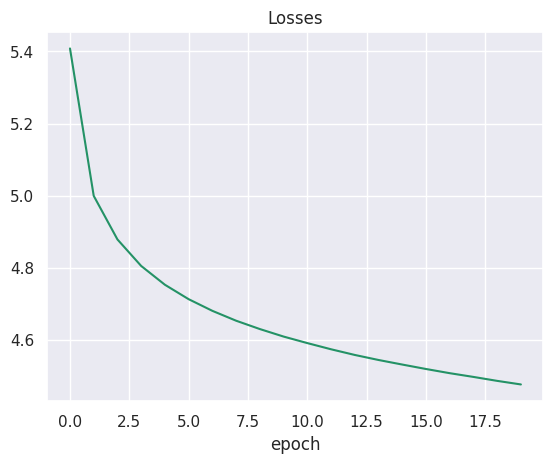

In [32]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

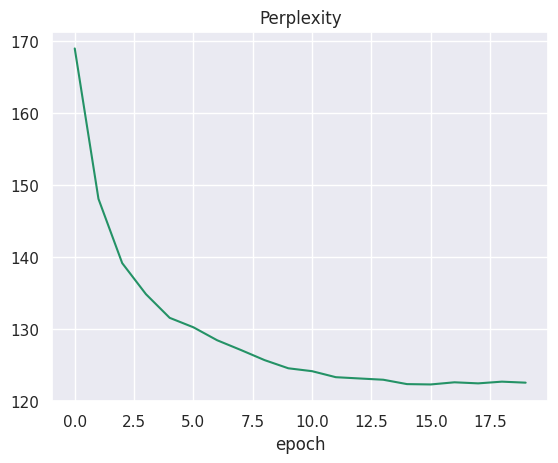

In [33]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [34]:
evaluate(model, criterion, test_dataloader)

121.84292956741076

In [35]:
torch.save(model.state_dict(), 'model_state_LanguageModel.pth')


In [36]:
# model = LanguageModel(hidden_dim=64, vocab_size=len(vocab))  # Параметры должны совпадать с теми, что были использованы при обучении

# model.load_state_dict(torch.load('/kaggle/input/my-models-to-check/model_state_LanguageModel.pth'))
# model.eval()  # Переводим модель в режим оценки, если собираемся использовать для инференса


In [37]:
!ls -la /kaggle/input

total 8
drwxr-xr-x 3 root   root    4096 Mar 19 09:29 .
drwxr-xr-x 6 root   root    4096 Mar 19 09:29 ..
drwxr-xr-x 2 nobody nogroup    0 Mar 18 18:40 my-models-to-check


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [38]:
# Проведите второй эксперимент
# Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm - хочу такое сделать


class LanguageModelLayerNorm(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # Добавляем слой LayerNorm после RNN и после первого линейного слоя
        self.layer_norm_rnn = nn.LayerNorm(hidden_dim)
        self.layer_norm_linear = nn.LayerNorm(hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm_rnn(output)  # Применяем LayerNorm после RNN
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm_linear(output)  # Применяем LayerNorm после первого линейного слоя
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]    
    
        return projection



In [39]:
model = LanguageModelLayerNorm(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [40]:
losses, perplexities = train_model(model, epochs=20)

Epoch 1: Average Loss = 5.3195, Perplexity = 157.8588
Epoch 2: Average Loss = 4.9386, Perplexity = 138.9693
Epoch 3: Average Loss = 4.8178, Perplexity = 131.3439
Epoch 4: Average Loss = 4.7442, Perplexity = 127.7571
Epoch 5: Average Loss = 4.6923, Perplexity = 125.5948
Epoch 6: Average Loss = 4.6526, Perplexity = 124.5296
Epoch 7: Average Loss = 4.6204, Perplexity = 123.5610
Epoch 8: Average Loss = 4.5929, Perplexity = 123.3086
Epoch 9: Average Loss = 4.5699, Perplexity = 122.8683
Epoch 10: Average Loss = 4.5502, Perplexity = 122.5119
Epoch 11: Average Loss = 4.5335, Perplexity = 122.3635
Epoch 12: Average Loss = 4.5184, Perplexity = 122.0932
Epoch 13: Average Loss = 4.5056, Perplexity = 122.3927
Epoch 14: Average Loss = 4.4937, Perplexity = 122.3762
Epoch 15: Average Loss = 4.4829, Perplexity = 122.4925
Epoch 16: Average Loss = 4.4725, Perplexity = 122.6139
Epoch 17: Average Loss = 4.4630, Perplexity = 122.7492
Epoch 18: Average Loss = 4.4539, Perplexity = 123.2489
Epoch 19: Average L

In [41]:
evaluate(model, criterion, test_dataloader)

123.44886458972177

In [42]:
torch.save(model.state_dict(), 'model_state_LanguageModelLayerNorm.pth')


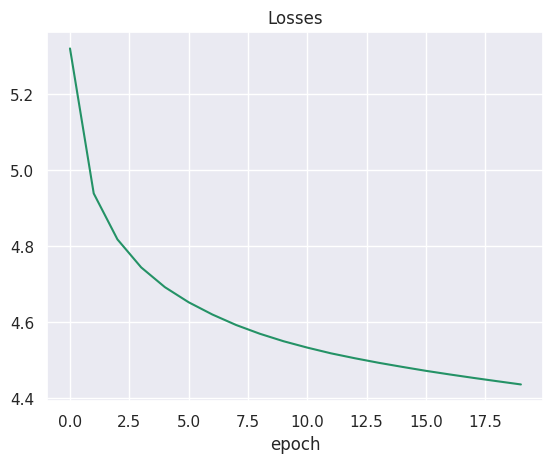

In [43]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

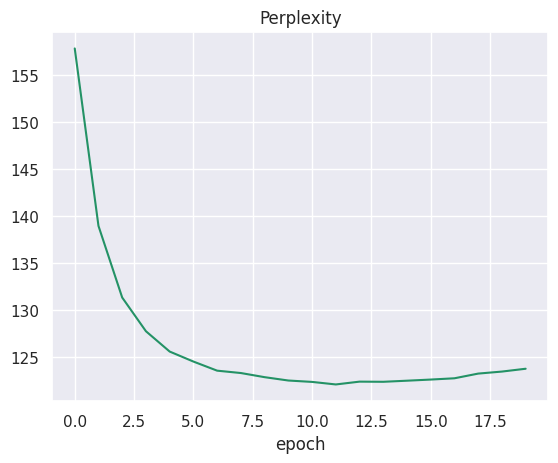

In [44]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Чтобы "всё работало":

1. уменьшил размер батча до batch_size = 16 (на семинарском 128 был ООМ)
2. hidden dim сделал 64
3. выкосил в обучении tqdm - в чатике говорили, что из-за него каггл может фризиться

попробовал 2 модели: 
1. "как в семинаре" (gru)
2. добавил LayerNorm 
    
у первой evaluate на тестовом датасете - 4.700847187153533; Perplexity = 4.6989

у второй evaluate на тестовом датасете -    ; Perplexity = 4.4523

2-я по преплексити лучше, но насколько это значимо, посмотрю на инференсе (только придумаю, как :-)

In [45]:
# model = LanguageModel(hidden_dim=64, vocab_size=len(vocab))  # Параметры должны совпадать с теми, что были использованы при обучении

# model.load_state_dict(torch.load('/kaggle/input/my-models-to-check/model_state_LanguageModel.pth'))
# model.eval()  # Переводим модель в режим оценки, если собираемся использовать для инференса

In [46]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [47]:
print(generate_sequence(model, starting_seq="Who"))

<bos> Who knows ? <eos>
